# Notes
Once the mounting above is complete, I'm thinking we manage our directory like:
- `models/` - maybe we can just store our models here?
- `results/` - any output statistics/graphs to visualize our results
- `utils/` - assuming we'll have at least some utility helper functions/classes

# Step 0a. Initial Setup

# Step 0b. Dependencies/Imports

In [1]:
from networks.FasterRCNN import FasterRCNN
from utils import AnchorBoxUtil, DataManager, ImageUtil
import torch
import torch.nn as nn
import gc

print(torch.version.cuda)

%load_ext autoreload
%autoreload 2

12.1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Current device is: {}'.format(device))

Current device is: cuda


# Step 0c. Data Preparation

In [ ]:
# data parameters
dataset_name = "voc-2007"
num_train = None
num_val = None
h_img_std = 480 # standard image height to resize to
w_img_std = 640 # standard image width to resize to

# # initial import from fiftyone.zoo
# dataset_train = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["train"],
#     max_samples=num_train
# )
# dataset_val = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["validation"],
#     max_samples=num_val
# )

# load images into tensors and parse out the target information (bounding boxes and labels)
data_train, data_val, str2id, id2str = DataManager.load_data(dataset_name, num_train, num_val, (h_img_std, w_img_std))

# Step 0d. Examples

## Example Using ImageUtil

In [ ]:
# data visualization tool
# session = fo.launch_app(dataset_train)

# example for using ImageUtil
example_idx = 0
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_train.images[example_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_train.labels[example_idx].tolist()] # get the actual label string(s)
example_bboxes = data_train.bboxes[example_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

## Generating Positive/Negative Anchors

In [ ]:
# generate anchor boxes
scales = [64, 128, 256, 512]
ratios = [0.5, 1, 2]
batch_size = data_train.images.shape[0]
features = torch.randn((batch_size, 1024, 15, 20))
anchor_bboxes, _ = AnchorBoxUtil.get_anchors_batch(data_train.images, scales, ratios, features, device='cpu')
train_bboxes = data_train.bboxes

# evaluate for positive and negative anchors
pos_thresh = 0.7
neg_thresh = 0.3

pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets, pos_anchors = AnchorBoxUtil.evaluate_anchor_bboxes_alt(anchor_bboxes, train_bboxes, data_train.labels, pos_thresh=0.7, neg_thresh=0.3, output_batch=256, pos_fraction=0.5)

top_n = 10
pos_classes = pos_classes[example_idx][:top_n]
pos_bboxes = pos_anchors[pos_coord_inds == example_idx][:top_n]

# display positives
lab = [id2str[i] for i in pos_classes.tolist()]
ImageUtil.build_image(example_image, pos_bboxes, lab, 'g', show=True)

# Step 1. Faster R-CNN

## Step 1a. Initialize Model

In [ ]:
# parameters
img_size = (h_img_std, w_img_std)
roi_size = (3, 3)
n_labels = len(str2id) - 1
pos_thresh = 0.7
neg_thresh = 0.3
nms_thresh = 0.7
top_n = 128
hidden_dim = 512
dropout = 0.2
backbone_size = (1024, 30, 40)
backbone = 'resnet50'

model = FasterRCNN(img_size, roi_size, n_labels, top_n, pos_thresh, neg_thresh, nms_thresh, hidden_dim, dropout, backbone, device=device)

## Step 1b. Training

In [ ]:
from utils import TrainingUtil

# parameters
learning_rate = 1e-3
momentum = 0.9
num_epochs = 20
batch_size = 10

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# initialize scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [11], gamma=0.1)

# run training
loss_results = TrainingUtil.train_model(model, optimizer, scheduler, data_train, data_val, num_epochs, batch_size, id2str, device=device, save=True)

In [ ]:
model.load_state_dict(torch.load('G:\\Dropbox (GaTech)\\CS7643_DL\\Mask_R-CNN\\results\\models\\2024-04-20_165658\\model.pt'))

## Step 1c. Evaluation

In [ ]:
model.eval()
proposals, labels = model.evaluate(data_val.images[0:10].to(device), device=device)

In [ ]:
eval_idx = 4
show_train = False
if show_train:
    data_tv = data_train
else:
    data_tv = data_val
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_tv.images[eval_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_tv.labels[eval_idx].tolist()] # get the actual label string(s)
example_bboxes = data_tv.bboxes[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

In [ ]:
eval_labels = [id2str[key] for key in labels[eval_idx].tolist()] # get the actual label string(s)
eval_bboxes = proposals[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, eval_bboxes, eval_labels, 'g')

## Step 1d. Comparison Against Other Pre-Trained Models

In [ ]:
# # code is adapted from: https://pytorch.org/vision/stable/models.html

# from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# # initialize weights
# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# # initialize model
# fpn_model = fasterrcnn_resnet50_fpn(weights=weights)

# # transform the input images
# preprocess = weights.transforms()
# image_set = [preprocess(image) for image in x_train]

# # evaluate the images
# output = fpn_model(image_set)

# # interpret the labels (bounding boxes live in output["boxes"])
# labels = [weights.meta["categories"][i] for i in output["labels"]]

# Step 2. Mask R-CNN

## Step 2a. Load COCO-2017

In [47]:
# data parameters
dataset_name = "coco-2017"
num_train = 12 #116000 # Subset
num_val = 12 # None # Default: 5000
h_img_std = 480 # standard image height to resize to
w_img_std = 640 # standard image width to resize to

# load images into tensors and parse out the target information (bounding boxes and labels)
data_train, data_val, str2id, id2str = DataManager.load_data(dataset_name, num_train, num_val, (h_img_std, w_img_std), load_masks=True)

Found annotations at '/home/cskroonenberg/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading 'coco-2017' split 'train'
 100% |███████████████████| 12/12 [66.5ms elapsed, 0s remaining, 180.3 samples/s]     
Dataset 'coco-2017-train-12' created
Found annotations at '/home/cskroonenberg/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 12/12 [71.2ms elapsed, 0s remaining, 168.5 samples/s]     
Dataset 'coco-2017-validation-12' created


Pre-processing [Validation] Dataset: 100%|██████████████████████████████████| 12/12 [00:00<00:00, 173.05it/s]


## Step 2b. Initialize Model

In [71]:
from networks.MaskRCNN import MaskRCNN

roi_size = (7, 7)
n_labels = len(str2id) - 1
pos_thresh = 0.7
neg_thresh = 0.3
nms_thresh = 0.7
hidden_dim = 512
dropout = 0.1
top_n = 128
mask_size=[28, 28]
mask_thresh = 0.5


model = MaskRCNN((h_img_std, w_img_std), roi_size, n_labels,
                   pos_thresh = pos_thresh,
                   neg_thresh = neg_thresh,
                   nms_thresh=nms_thresh,
                   hidden_dim = hidden_dim,
                   dropout = dropout,
                   top_n = top_n,
                   device = device,
                   mask_size = mask_size,
                   mask_thresh=mask_thresh)

## Step 2c. Training

In [72]:
learning_rate = 5e-3 # 1e-3
weight_decay=0.0001
momentum = 0.9
num_epochs = 180
batch_size = 12 # 16
lr_steps = [80] # [16]

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# initialize scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, lr_steps, gamma=0.1)

len(data_train): 12
------------------------------------------------------------
Running Epoch: 01 / 180
Training Model: 100%|██████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]
all loss backprop
Running Validation: 100%|██████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0,

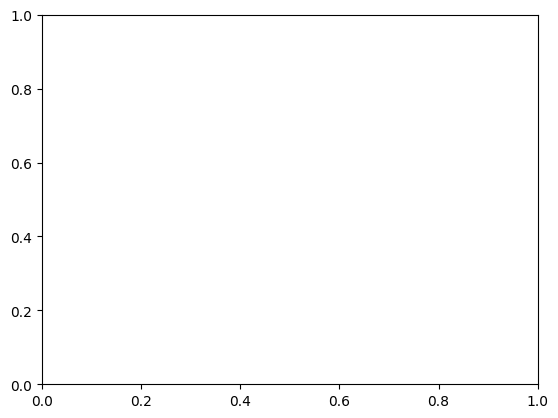

In [73]:
from utils import TrainingUtil
# run training

torch.autograd.set_detect_anomaly(True)

mask_plot_freq = 1

loss_results = TrainingUtil.train_model(model, optimizer, scheduler, data_train, data_val, num_epochs, batch_size, id2str, device=device, save=True, mask_plot_freq=mask_plot_freq)

In [74]:
torch.cuda.empty_cache()

## Step 2d. Evaluation

In [ ]:
checkpoint_path = None # TODO
model.load_state_dict(checkpoint_path)

In [ ]:
model.eval()
proposals, labels, masks = model.evaluate(data_val.images[0:10].to(device), device=device)

In [ ]:
raise NotImplementedError
# Model metrics
# Model visuals
# Etc.